In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../openTCGA/")
sys.path.insert(0, "../MultiOmicsGraphEmbedding//")

import os, pickle, random, itertools
import networkx as nx
import numpy as np
import pandas as pd
import dask.dataframe as dd
import scipy.sparse as sps
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from openomics import MultiOmics, Protein, MessengerRNA, MicroRNA, LncRNA
from openomics.database import *
from openomics.genomics import *

from moge.visualization.data import matrix_heatmap, plot_coo_matrix
from moge.visualization.embedding import visualize_embedding
from moge.visualization.network import graph_viz
from moge.network.semantic_similarity import *

pd.set_option('mode.chained_assignment', 'raise')

/opt/anaconda3/lib/python3.6/site-packages/umap/spectral.py:4: NumbaDeprecationWarning:

No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!



# Load datasets

In [ ]:
gencode = GENCODE(path="ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_32/",
                  file_resources={"long_noncoding_RNAs.gtf": "gencode.v32.long_noncoding_RNAs.gtf.gz",
                                  "basic.annotation.gtf": "gencode.v32.basic.annotation.gtf.gz",
                                  "lncRNA_transcripts.fa": "gencode.v32.lncRNA_transcripts.fa.gz",
                                  "transcripts.fa": "gencode.v32.transcripts.fa.gz"},
                  remove_version_num=True, replace_U2T=True)

rnacentral = RNAcentral(path="ftp://ftp.ebi.ac.uk/pub/databases/RNAcentral/current_release/", verbose=True,)

mirbase = MirBase(path="ftp://mirbase.org/pub/mirbase/CURRENT/", sequence="hairpin", species="Homo sapiens", 
                  species_id=9606, replace_U2T=True)

ensembl = EnsemblGenes()

go = GeneOntology()

proteinatlas = ProteinAtlas()

gtex = GTEx(path="https://storage.googleapis.com/gtex_analysis_v8/rna_seq_data/")

# Import the TCGA cancer data

In [ ]:
cohort_name = "GTEx"

gtex_transcripts = gtex.df

gtex_transcripts_gene_id = pd.Index(gtex_transcripts["gene_id"].unique())
gtex_transcripts_gene_name = pd.Index(gtex_transcripts["gene_name"].unique())

In [5]:
messengerRNA_id = pd.Index(gencode.df[gencode.df["gene_type"] == "protein_coding"]["gene_id"].unique()) & gtex_transcripts_gene_id

messengerRNA = MessengerRNA(cohort_name, data=gtex_transcripts[gtex_transcripts["gene_id"].isin(messengerRNA_id)], 
                            transposed=True, gene_index_by="gene_name", columns=None)

In [ ]:
# microRNA_id = pd.Index(ensembl.df[ensembl.df["gene_biotype"] == "miRNA"]["gene_id"].unique()) & gtex_transcripts_gene_id

# microRNA = MicroRNA(cohort_name, data=gtex_transcripts[gtex_transcripts["gene_id"].isin(microRNA_id)], 
#                     gene_index_by="gene_id", transposed=True, columns=None, )
# microRNA.expressions.head()

In [7]:
lncRNA_id = pd.Index(gencode.df[gencode.df["gene_type"] == "lncRNA"]["gene_id"].unique()) & gtex_transcripts_gene_id
lncRNA = LncRNA(cohort_name, data=gtex_transcripts[gtex_transcripts["gene_id"].isin(lncRNA_id)], 
                gene_index_by="gene_id", transposed=True, columns=None, )

In [ ]:
protein_expressions = proteinatlas.get_expressions(index="protein_name", type="RNA - ").reset_index()
protein = Protein(cohort_name, data=protein_expressions,
                     gene_index_by="protein_name", transposed=True, columns=None, dropna=False)
protein.expressions.head()

In [ ]:
cohort_name = "GTEx"
gtex_data = MultiOmics(cohort_name)

gtex_data.add_omic(protein)

gtex_data.add_omic(messengerRNA)

# # gtex_data.add_omic(microRNA)
gtex_data.add_omic(MicroRNA(cohort_name, 
                            data=os.path.join("/data/datasets/Bioinformatics_ExternalData/tcga-assembler/LUAD/", "mirna/", "miRNAExp__RPM.txt"), 
                            gene_index_by="GeneSymbol", transposed=True,
                            columns="GeneSymbol|TCGA"))
gtex_data.MicroRNA.expressions.index.name = "gene_name"
gtex_data.MicroRNA.initialize_annotations(gtex_data.MicroRNA.get_genes_list(), "gene_name")

gtex_data.add_omic(lncRNA)
gtex_data.build_samples()

# Import Interaction & Disease association database

In [2]:
lncbase = LncBase("/data/datasets/Bioinformatics_ExternalData/lncBase/", strip_mirna_name=True, 
                  filters={"species": "Homo sapiens"})
mirtarbase = MiRTarBase(path="/data/datasets/Bioinformatics_ExternalData/miRTarBase/", strip_mirna_name=True,
                        filters={"Species (Target Gene)": "Homo sapiens"})
string = STRING(species_id='9606')
biogrid = BioGRID(edge_attr=['Score', 'Throughput', 'Experimental System', 'Experimental System Type'], 
                  filters={"Organism Interactor A": 9606})

LncBase ['geneId', 'geneName', 'mirna', 'species', 'cell_line', 'tissue', 'category', 'method', 'positive_negative', 'direct_indirect', 'condition']
INFO: Removed 14670 rows with `species` != Homo sapiens
MiRTarBase ['miRTarBase ID', 'miRNA', 'Species (miRNA)', 'Target Gene', 'Target Gene (Entrez ID)', 'Species (Target Gene)', 'Experiments', 'Support Type', 'References (PMID)']
INFO: Removed 54530 rows with `Species (Target Gene)` != Homo sapiens
STRING: ['item_id_a', 'item_id_b', 'mode', 'action', 'is_directional', 'a_is_acting', 'score']


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DtypeWarning:

Columns (9,10,19,20) have mixed types.Specify dtype option on import or set low_memory=False.



BioGRID: ['#BioGRID Interaction ID', 'Entrez Gene Interactor A', 'Entrez Gene Interactor B', 'BioGRID ID Interactor A', 'BioGRID ID Interactor B', 'Systematic Name Interactor A', 'Systematic Name Interactor B', 'Official Symbol Interactor A', 'Official Symbol Interactor B', 'Synonyms Interactor A', 'Synonyms Interactor B', 'Experimental System', 'Experimental System Type', 'Author', 'Pubmed ID', 'Organism Interactor A', 'Organism Interactor B', 'Throughput', 'Score', 'Modification', 'Phenotypes', 'Qualifications', 'Tags', 'Source Database']
INFO: Removed 1236114 rows with `Organism Interactor A` != 9606


In [4]:
lncRNA_name_to_id = gtex_data.LncRNA.annotations.reset_index().set_index("gene_name")["gene_id"].to_dict()
lncrna2target = LncRNA2Target(path="/data/datasets/Bioinformatics_ExternalData/lncrna2target/",
                              file_resources={"lncRNA_target_from_high_throughput_experiments.txt": "/data/datasets/Bioinformatics_ExternalData/lncrna2target/lncRNA_target_from_high_throughput_experiments.txt"}, 
                              version="high_throughput", relabel_nodes=lncRNA_name_to_id,
                              filters={"species_id": 9606, "Species": "Homo sapiens"},)

../openTCGA/openomics/database/interaction.py:418: DtypeWarning:

Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.



LncRNA2Target ['species_id', 'experiment_id', 'lncrna_symbol', 'gene_symbol', 'entrez_gene_id', 'log2FC', 'test_statistic', 'P_Value', 'adjusted_P_Value', 'direction']


In [5]:
npinter = NPInter(filters={"organism": "Homo sapiens", 
                           "level": "RNA-Protein", 
                           "ncType": "lncRNA"}, relabel_nodes=lncRNA_name_to_id)

NPInter ['interID', 'ncName', 'ncID', 'ncType', 'tarName', 'tarID', 'tarType', 'interDescription', 'experiment', 'reference', 'organism', 'tissueOrCell', 'tag', 'class', 'level', 'datasource']
INFO: Removed 632 rows with `organism` != Homo sapiens
INFO: Removed 1230 rows with `level` != RNA-Protein
INFO: Removed 44 rows with `ncType` != lncRNA


In [30]:
npinter.get_interactions(data=True)

OutEdgeDataView([('7SK', 'HEXIM1', {'tarType': 'protein', 'tissueOrCell': nan, 'tag': 'ncRNA-protein binding', 'level': 'RNA-Protein'}), ('7SK', 'CDK9', {'tarType': 'protein', 'tissueOrCell': nan, 'tag': 'ncRNA-protein binding', 'level': 'RNA-Protein'}), ('7SK', 'HMGA1', {'tarType': 'protein', 'tissueOrCell': nan, 'tag': 'ncRNA-protein binding', 'level': 'RNA-Protein'}), ('7SK', 'BRF1', {'tarType': 'protein', 'tissueOrCell': nan, 'tag': 'ncRNA affects synthesis or function of protein', 'level': 'RNA-Protein'}), ('BC200', 'PABPC1', {'tarType': 'protein', 'tissueOrCell': nan, 'tag': 'ncRNA-protein binding', 'level': 'RNA-Protein'}), ('BC200', 'FMR1', {'tarType': 'protein', 'tissueOrCell': nan, 'tag': 'ncRNA-protein binding', 'level': 'RNA-Protein'}), ('BC200', 'SYNCRIP', {'tarType': 'protein', 'tissueOrCell': 'human brain', 'tag': 'ncRNA-protein binding', 'level': 'RNA-Protein'}), ('ENSG00000262117', 'PNUTS', {'tarType': 'protein', 'tissueOrCell': 'Breast tissue', 'tag': 'ncRNA-protein b

In [12]:
# Disease association datasets
disgenet = DisGeNet(path="https://www.disgenet.org/static/disgenet_ap1/files/downloads/", curated=True)
hmdd = HMDD(path="http://www.cuilab.cn/static/hmdd3/data/")
lncrnadisease = LncRNADisease(path="http://www.cuilab.cn/files/images/ldd/", species="Human")
# malacards = MalaCards()

# Annotate Data

In [13]:
# LncRNA
gtex_data.LncRNA.annotate_genomics(gencode, index="gene_id", 
                                   columns=['feature', 'start', 'end', 'strand', 'tag', 'havana_gene'])
gtex_data.LncRNA.annotate_genomics(database=ensembl, index='gene_id', 
                                   columns=['gene_name', 'transcript_id', 'transcript_name', 
                                         'chromosome_name', 'transcript_start', 'transcript_end', 'transcript_length',
                                         'Rfams', 'go_id', 'gene_biotype', 'transcript_biotype'])
gtex_data.LncRNA.annotate_genomics(database=rnacentral, index='gene_name',
                                   columns=['Rfams', 'go_id', 'gene_name'])
gtex_data.LncRNA.annotate_diseases(lncrnadisease, index="gene_name", )
gtex_data.LncRNA.annotate_sequences(gencode, index="gene_id", omic="LncRNA", agg_sequences="longest")
gtex_data.LncRNA.annotations.info()

INFO: You can pass in a list of transcript biotypes to filter using the argument 'biotypes'.
<class 'pandas.core.frame.DataFrame'>
Index: 13729 entries, ENSG00000082929 to ENSG00000284600
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   gene_name             13729 non-null  object
 1   feature               13729 non-null  object
 2   start                 13729 non-null  object
 3   end                   13729 non-null  object
 4   strand                13729 non-null  object
 5   tag                   13729 non-null  object
 6   havana_gene           13729 non-null  object
 7   transcript_id         13729 non-null  object
 8   transcript_name       13729 non-null  object
 9   chromosome_name       13729 non-null  object
 10  transcript_start      13729 non-null  object
 11  transcript_end        13729 non-null  object
 12  transcript_length     13729 non-null  object
 13  Rfams                 16

In [36]:
# MessengerRNA
gtex_data.MessengerRNA.annotate_genomics(database=rnacentral, index="gene_name",
                                columns=['gene_name', 'transcript_id', 'RNA type', 'go_id', 'Rfams'])
gtex_data.MessengerRNA.annotate_genomics(database=ensembl, index='gene_name',
                                columns=['gene_id', 'transcript_id', 'transcript_name', 
                                         'chromosome_name', 'transcript_start', 'transcript_end', 'transcript_length',
                                         'Rfams', 'go_id', 'gene_biotype', 'transcript_biotype'])
gtex_data.MessengerRNA.annotate_sequences(gencode, index="gene_name", omic="MessengerRNA", 
                                          agg_sequences="longest", biotypes=["protein_coding"])
gtex_data.MessengerRNA.annotate_diseases(disgenet, index="gene_name", )
gtex_data.MessengerRNA.annotations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19231 entries, A1BG to ZZZ3
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   transcript_id         18660 non-null  object
 1   RNA type              0 non-null      object
 2   go_id                 18185 non-null  object
 3   Rfams                 2 non-null      object
 4   gene_id               18660 non-null  object
 5   transcript_name       18660 non-null  object
 6   chromosome_name       18660 non-null  object
 7   transcript_start      18660 non-null  object
 8   transcript_end        18660 non-null  object
 9   transcript_length     18660 non-null  object
 10  gene_biotype          18660 non-null  object
 11  transcript_biotype    18660 non-null  object
 12  Transcript sequence   18668 non-null  object
 13  disease_associations  8799 non-null   object
dtypes: object(14)
memory usage: 2.2+ MB


In [51]:
# MicroRNA
gtex_data.MicroRNA.annotate_genomics(
    database=mirbase, index="gene_name", 
    columns=['mirbase id', 'RNAcentral id', 'database'],)
gtex_data.MicroRNA.annotate_genomics(
    database=rnacentral, index="RNAcentral id",
    columns=['transcript_id', 'RNA type', 'go_id', 'Rfams']
)
gtex_data.MicroRNA.annotate_genomics(
    database=ensembl, index='gene_name',
    columns=['gene_name', 'transcript_id', 'transcript_name', 
             'chromosome_name', 'transcript_start', 'transcript_end', 'transcript_length',
             'Rfams', 'go_id', 'gene_biotype', 'transcript_biotype'])
gtex_data.MicroRNA.annotate_diseases(hmdd, index="gene_name", )
gtex_data.MicroRNA.annotate_sequences(mirbase, index="gene_name", omic="MicroRNA", agg_sequences="all")
gtex_data.MicroRNA.annotations.info()

Using cached self.seq_dict
<class 'pandas.core.frame.DataFrame'>
Index: 1870 entries, hsa-let-7a-1 to hsa-mir-99b
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   RNAcentral id         1839 non-null   object
 1   mirbase id            1839 non-null   object
 2   database              1839 non-null   object
 3   transcript_id         496 non-null    object
 4   RNA type              496 non-null    object
 5   go_id                 496 non-null    object
 6   Rfams                 496 non-null    object
 7   transcript_name       2 non-null      object
 8   chromosome_name       2 non-null      object
 9   transcript_start      2 non-null      object
 10  transcript_end        2 non-null      object
 11  transcript_length     2 non-null      object
 12  gene_biotype          2 non-null      object
 13  transcript_biotype    2 non-null      object
 14  disease_associations  934 non-null    object
 15

In [54]:
# # Protein
gtex_data.Protein.annotate_sequences(string, index="protein_name")
gtex_data.Protein.annotate_genomics(string, index="protein_name", 
                                    columns=['protein_size', 'protein_id', 'annotation'])
gtex_data.Protein.annotations["gene_name"] = gtex_data.Protein.annotations.index.get_level_values("protein_name")
gtex_data.Protein.annotate_genomics(database=go, index="gene_name", columns=['go_id'])
gtex_data.Protein.annotate_genomics(database=proteinatlas, index="protein_name", 
                                    columns=['Protein class', 'Uniprot', 'Chromosome', 'Position', 'Antibody',
                                             'Subcellular location'])
gtex_data.Protein.annotate_diseases(disgenet, index="gene_name", )
gtex_data.Protein.annotations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19651 entries, A1BG to ZZEF1
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   gene_name             19651 non-null  object
 1   Transcript sequence   18343 non-null  object
 2   protein_size          18343 non-null  object
 3   protein_id            18343 non-null  object
 4   annotation            18343 non-null  object
 5   go_id                 18329 non-null  object
 6   Protein class         19651 non-null  object
 7   Uniprot               18942 non-null  object
 8   Chromosome            19651 non-null  object
 9   Position              19651 non-null  object
 10  Antibody              17044 non-null  object
 11  Subcellular location  12382 non-null  object
 12  disease_associations  8871 non-null   object
dtypes: object(13)
memory usage: 2.1+ MB


In [55]:
# luad_data.LncRNA.annotate_diseases(malacards, index="gene_name", )
# luad_data.MicroRNA.annotate_diseases(malacards, index="gene_name", )
# luad_data.MessengerRNA.annotate_diseases(malacards, index="gene_name", )
# luad_data.Protein.annotate_diseases(malacards, index="gene_name", )

In [56]:
# luad_data.MessengerRNA.annotate_expressions(database=gtex, index="gene_name")
# luad_data.LncRNA.annotate_expressions(database=gtex, index="gene_id")
# luad_data.MicroRNA.annotate_expressions(database=gtex, index="gene_name")
# luad_data.Protein.annotate_expressions(database=gtex, index="gene_name")

In [68]:
LNC = gtex_data.LncRNA.get_annotations()
MIR = gtex_data.MicroRNA.get_annotations()
GE = gtex_data.MessengerRNA.get_annotations()
PRO = gtex_data.Protein.get_annotations()
print(GE.info())
print(MIR.info())
print(LNC.info())
print(PRO.info())

<class 'pandas.core.frame.DataFrame'>
Index: 19231 entries, A1BG to ZZZ3
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   transcript_id         18660 non-null  object
 1   RNA type              0 non-null      object
 2   go_id                 19231 non-null  object
 3   Rfams                 2 non-null      object
 4   gene_id               18660 non-null  object
 5   transcript_name       18660 non-null  object
 6   chromosome_name       18660 non-null  object
 7   transcript_start      18660 non-null  object
 8   transcript_end        18660 non-null  object
 9   transcript_length     18660 non-null  object
 10  gene_biotype          18660 non-null  object
 11  transcript_biotype    18660 non-null  object
 12  sequence              18668 non-null  object
 13  disease_associations  8799 non-null   object
dtypes: object(14)
memory usage: 2.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 187

# Make an ancestor array of GO terms

In [66]:
filted_go_annotations = go.filter_annotation(gtex_data.LncRNA.annotations["go_id"].str.split("|"))
gtex_data.LncRNA.annotations["go_id"] = go.add_predecessor_terms(filted_go_annotations, return_str=True)

filted_go_annotations = go.filter_annotation(gtex_data.MicroRNA.annotations["go_id"].str.split("|"))
gtex_data.MicroRNA.annotations["go_id"] = go.add_predecessor_terms(filted_go_annotations, return_str=True)

filted_go_annotations = go.filter_annotation(gtex_data.MessengerRNA.annotations["go_id"].str.split("|"))
gtex_data.MessengerRNA.annotations["go_id"] = go.add_predecessor_terms(filted_go_annotations, return_str=True)

filted_go_annotations = go.filter_annotation(gtex_data.Protein.annotations["go_id"].str.split("|"))
gtex_data.Protein.annotations["go_id"] = go.add_predecessor_terms(filted_go_annotations, return_str=True)

In [60]:
assert not gtex_data.LncRNA.annotations["sequence"].str.contains("U").any()
assert not gtex_data.MicroRNA.annotations["sequence"].str.contains("U").any()
assert not gtex_data.MessengerRNA.annotations["sequence"].str.contains("U").any()

In [67]:
# with open('data/gtex_rna_ppi_data_go_parents.pickle', 'wb') as file:
# #     luad_data = pickle.load(file)
#     pickle.dump(gtex_data, file)

# Build Heterogeneous Network

In [3]:
import pickle
with open('data/gtex_rna_ppi_data_go_parents.pickle', 'rb') as file:
    gtex_data = pickle.load(file)

In [6]:
gtex_data.Protein.annotations["gene_biotype"] = "protein"
gtex_data.Protein.annotations["Rfams"] = gtex_data.Protein.annotations["Protein class"].str.replace(", ", "|")

In [8]:
from moge.network.multiplex import MultiplexAttributedNetwork
from networkx import Graph, DiGraph

network = MultiplexAttributedNetwork(multiomics=gtex_data,
                                     modalities=["MicroRNA", "MessengerRNA", "LncRNA", "Protein"], 
                                     layers={
                                         (MicroRNA.name(), MessengerRNA.name()): DiGraph,
                                         (MicroRNA.name(), LncRNA.name()): DiGraph,
                                         (LncRNA.name(), MessengerRNA.name()): DiGraph,
                                         (LncRNA.name(), Protein.name()): DiGraph,
                                         (Protein.name(), Protein.name()): Graph,
                                     })
network.all_annotations.columns

MicroRNA  nodes: 1870 GeneSymbol
MessengerRNA  nodes: 19231 gene_name
LncRNA  nodes: 13729 gene_id
Protein  nodes: 19651 protein_name
Total nodes: 35651
All annotation columns (union): {'Protein class', 'Uniprot', 'annotation', 'gene_id', 'chromosome_name', 'transcript_id', 'Subcellular location', 'transcript_name', 'protein_id', 'strand', 'transcript_start', 'protein_size', 'database', 'gene_name', 'feature', 'RNAcentral id', 'mirbase id', 'sequence', 'go_id', 'Rfams', 'Chromosome', 'RNA type', 'Antibody', 'gene_biotype', 'transcript_length', 'transcript_end', 'end', 'tag', 'Position', 'start', 'havana_gene', 'transcript_biotype', 'disease_associations'}


Index(['go_id', 'Rfams', 'gene_biotype', 'disease_associations', 'sequence',
       'omic'],
      dtype='object')

In [63]:
edges[('hsa-mir-20a', 'CRIM1')]

{'Support Type': 'Functional MTI'}

In [9]:
network.add_edges(mirtarbase.get_interactions(nodelist=network.node_list, data=True), 
                  database=mirtarbase.name(), directed=True,
                  layer=(MicroRNA.name(), MessengerRNA.name())
                 )
network.add_edges(lncbase.get_interactions(nodelist=network.node_list, data=True), 
                  database=lncbase.name(), directed=True,
                  layer=(MicroRNA.name(), LncRNA.name())
                 )
network.add_edges(lncrna2target.get_interactions(nodelist=network.node_list, data=True), 
                  database=lncrna2target.name(), directed=True,
                  layer=(LncRNA.name(), MessengerRNA.name())
                 )
network.add_edges(npinter.get_interactions(network.node_list, data=True), 
                  database=string.name(), directed=True,
                  layer=(LncRNA.name(), Protein.name())
                 )
network.add_edges(string.get_interactions(network.node_list, data=True, inclusive=True), 
                  database=string.name(), directed=False,
                  layer=(Protein.name(), Protein.name())
                 )

338961 edges added to self.networks[('MicroRNA', 'MessengerRNA')]
18989 edges added to self.networks[('MicroRNA', 'LncRNA')]
33892 edges added to self.networks[('LncRNA', 'MessengerRNA')]
163 edges added to self.networks[('LncRNA', 'Protein')]
517797 edges added to self.networks[('Protein', 'Protein')]


In [26]:
assert network.networks[('MicroRNA', 'LncRNA')].number_of_edges() > 0

In [12]:
network.split_stratified(stratify_label="go_id", stratify_omic=True, n_splits=10, 
                         dropna=False, verbose=True)

label go_id filtered: 10584 with min_count=10


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



train 31070 test 3437
train 31051 test 3456
train 31060 test 3447
train 31044 test 3463
train 31077 test 3430
train 31053 test 3454
train 31055 test 3452
train 31057 test 3450
train 31044 test 3463
train 31052 test 3455


In [13]:
with open('data/gtex_rna_ppi_multiplex_network.pickle', "wb") as file:
#     network = pickle.load(file)
    pickle.dump(network, file)

#  Analyze Network

In [3]:
with open('data/gtex_rna_ppi_multiplex_network.pickle', "rb") as file:
    network = pickle.load(file)

In [77]:
node_clustering = pd.DataFrame(index=network.node_list, columns=columns)
for layer in network.layers:
    clustering_scores = nx.clustering(network.networks[layer], nodes=network.node_list)
    node_clustering["-".join(layer)] = node_clustering.index.map(lambda x: clustering_scores.get(x))
    

In [82]:
for layer in network.layers:
    print(f"{layer} {nx.transitivity(network.networks[layer])}")

('MicroRNA', 'MessengerRNA') 0
('MicroRNA', 'LncRNA') 0
('LncRNA', 'MessengerRNA') 0
('Protein', 'Protein') 0.3635177096478977


In [14]:
columns = ["-".join(col) for col in network.layers]
node_degrees = pd.DataFrame(index=network.node_list, columns=columns)

for node in network.node_list:
    overlap_edges = 0
    union_edges = 0
    for layer_1 in network.layers.keys():
        node_degrees.loc[node, "-".join(layer_1)] = network.networks[layer_1].degree(node)
        for layer_2 in network.layers.keys():
            if layer_1 == layer_2: continue
            overlap_edges += len(set(network.networks[layer_1].edges(node)) & set(network.networks[layer_2].edges(node)))
            union_edges += len(set(network.networks[layer_1].edges(node)) | set(network.networks[layer_2].edges(node)))
    if overlap_edges > 0:
        print(node+ " overlap_edges", overlap_edges)
node_degrees["Combined"] = node_degrees.sum(1)
node_degrees = node_degrees.sort_values(by="Combined", ascending=False)

hsa-mir-185 overlap_edges 2
FOXF1 overlap_edges 6
MTX2 overlap_edges 4
STXBP5 overlap_edges 6
TNS1 overlap_edges 22
ZEB2 overlap_edges 2
ENSG00000234741 overlap_edges 2
ENSG00000251562 overlap_edges 4


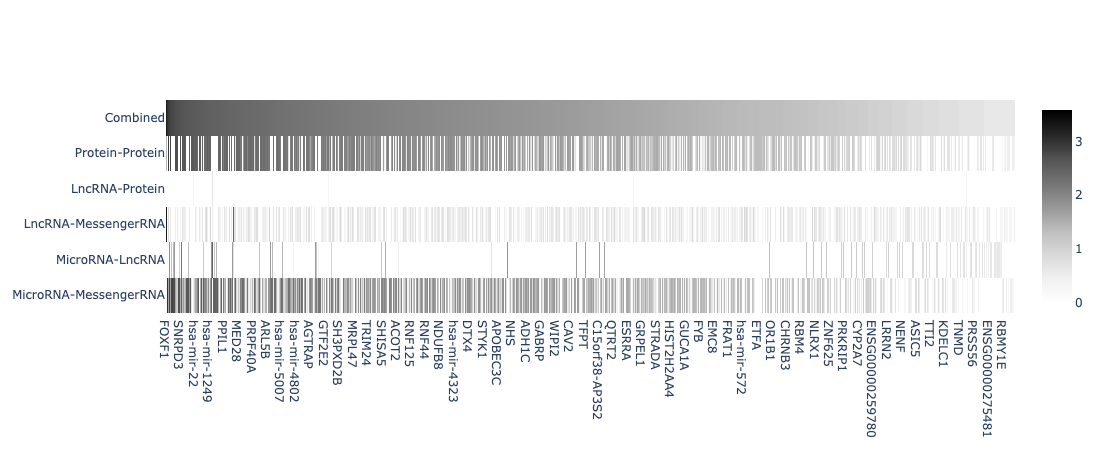

In [22]:
go.Figure(data=go.Heatmap(z=node_degrees.applymap(lambda x: np.log10(x+1)).T, 
                          x=node_degrees.index[:20000], y=node_degrees.columns, colorscale="Greys"))

# Visualize Network

In [ ]:
nodelist = network.annotations[network.annotations["omic"].str.contains("MicroRNA|LncRNA")].index
nodelist = [k for k, v in network.G.subgraph(nodelist).degree() if v > 0 and k in nodelist]
len(nodelist)

In [ ]:
graph_viz(network.G, nodelist=nodelist, 
#           node_symbol=network.annotations.loc[nodelist, "disease_associations"], 
          node_color=network.annotations.loc[nodelist, "omic"], 
          edge_label="database",
          iterations=100,
          max_edges=3000)

# Add Attribute Affinity Positive Edges

In [ ]:
affinities_GE = network.add_edges_from_nodes_similarity(modality="GE", node_list=network.nodes["GE"], 
    similarity_threshold=0.80, dissimilarity_threshold=0.01,
    negative_sampling_ratio=5.0, nanmean=True,
    features=["GO Terms", "Disease association"],
    weights=[1, 1],
    compute_correlation=False)

In [ ]:
affinities_GE = network.add_edges_from_nodes_similarity(modality="GE", node_list=network.nodes["GE"], 
    similarity_threshold=0.85, dissimilarity_threshold=0.01,
    negative_sampling_ratio=5.0, nanmean=False,
    features=["locus_type", "gene_family_id", "location"], 
    weights=[0.5, 1, 0.5, 1],
    compute_correlation=True, tissue_expression=GE_tissue_exp)

In [ ]:
affinities_MIR = network.add_edges_from_nodes_similarity(modality="MIR", node_list=network.nodes["MIR"], 
    similarity_threshold=0.70, dissimilarity_threshold=0.01,
    negative_sampling_ratio=5.0, nanmean=True,
    features=["GO Terms", "Disease association"], 
    compute_correlation=False)

In [ ]:
affinities_MIR = network.add_edges_from_nodes_similarity(modality="MIR", node_list=network.nodes["MIR"], 
    similarity_threshold=0.70, dissimilarity_threshold=0.01,
    negative_sampling_ratio=5.0, nanmean=True,
    features=["Family", "Rfams"], 
    compute_correlation=True, tissue_expression=MIR_tissue_exp)

In [ ]:
affinities_LNC = network.add_edges_from_nodes_similarity(modality="LNC", node_list=network.nodes["LNC"], 
    similarity_threshold=0.90, dissimilarity_threshold=0.1,
    negative_sampling_ratio=5.0, 
    nanmean=False,
    features=["locus_type", "Transcript type", "tag", "Strand", "Chromosome"],
    weights=[1, 1, 0.5, 0.5, 1, 1],
    compute_correlation=True, tissue_expression=LNC_tissue_exp)

In [ ]:
affinities_LNC = network.add_edges_from_nodes_similarity(modality="LNC", node_list=network.nodes["LNC"], 
    similarity_threshold=0.70, dissimilarity_threshold=0.01,
    negative_sampling_ratio=5.0, nanmean=True,
    features=["GO Terms", "Family", "Disease association"], 
    compute_correlation=False)

In [ ]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u"], node_list=network.nodes["GE"]).todense(),
              figsize=(7,7))

In [ ]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u"], node_list=network.nodes["MIR"]).todense(),
              figsize=(5,5))

In [ ]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u"], node_list=network.nodes["LNC"]).todense(),
              figsize=(7,7))

In [ ]:
# # IMPORT Affinity Edgelist
# network.import_edgelist_file(
# #     file="moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/lmn_n70_m70_l70-70_TissueExp_GO_Rfams_Disease_Family_GO_affinity.edgelist", 
#     file="moge/data/LMN_future_recall/TRAIN/Interactions_Only/GE/lmn_train.BioGRID.interactions.edgelist", 
#     is_directed=True)

# network.import_edgelist_file(
#     file="moge/data/LMN_future_recall/TRAIN/Interactions_Only/MIR/lmn_train.miRTarBase.interactions.edgelist", 
#     is_directed=True)

# network.import_edgelist_file(
#     file="moge/data/LMN_future_recall/TRAIN/Interactions_Only/LNC/lmn_train.lncBase.interactions.edgelist", 
#     is_directed=True)

# network.import_edgelist_file(
#     file="moge/data/LMN_future_recall/TRAIN/Interactions_Only/LNC/lmn_train.lncrna2target.interactions.edgelist", 
#     is_directed=True)

In [ ]:
# WRITE Affinity Edgelist
# nx.write_edgelist(network.get_subgraph(["MIR", "GE", "LNC"], edge_type="u"), 
#                   "moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/lmn_n70_m70_l70-70_TissueExp_GO_Rfams_Disease_Family_GO_affinity.edgelist", 
#                   data=True)

# Add Attribute Affinity NEGATIVE Edges between cross-modals

In [ ]:
u_n_size = 10000
network.add_sampled_negative_edges(u_n_size, modalities=["GE", "MIR"])
network.add_sampled_negative_edges(u_n_size*2, modalities=["GE", "LNC"])
network.add_sampled_negative_edges(u_n_size, modalities=["LNC", "MIR"])

# miRTarBase

In [ ]:
mirtarbase_new = luad_data.MIR.get_miRTarBase_miRNA_target_interaction(use_latest=True, data=False, rename_dict=case_relabel)
mirtarbase_old = luad_data.MIR.get_miRTarBase_miRNA_target_interaction(use_latest=False, data=False, rename_dict=case_relabel)
mirtarbase_diff = list(set(mirtarbase_new) - set(mirtarbase_old))
len(mirtarbase_diff)

In [ ]:
# Adds miRNA-target interaction network
network.add_directed_edges_from_edgelist(edgelist=luad_data.MIR.get_miRTarBase_miRNA_target_interaction(use_latest=False),
#                                                                                                        rename_dict=case_relabel), 
                                        modalities=["MIR", "GE"], correlation_weights=False, threshold=0.20,
                                        database="miRTarBase")

# StarBase mRNA-RNA

In [ ]:
starbase_new = luad_data.GE.get_starBase_RNA_RNA_interactions(min_expNum=1, data=False)
starbase_old = luad_data.GE.get_starBase_RNA_RNA_interactions(min_expNum=2, data=False)
starbase_diff = list(set(starbase_new) - set(starbase_old))
len(starbase_diff)

In [ ]:
# Adds Gene Regulatory Network edges
network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_starBase_lncRNA_RNA_interactions(),
                                        modalities=["LNC", "GE"], correlation_weights=False, threshold=0.2,
                                        database="starBase")

# BioGRID

In [ ]:
biogrid_new = luad_data.GE.get_BioGRID_GRN_edgelist(data=False, rename_dict=case_relabel,
                biogrid_interactions_file_path='/data/datasets/Bioinformatics_ExternalData/BioGRID/BIOGRID-ALL-3.5.169.tab2.txt')
biogrid_old = luad_data.GE.get_BioGRID_GRN_edgelist(data=False, rename_dict=case_relabel,
                biogrid_interactions_file_path='/data/datasets/Bioinformatics_ExternalData/BioGRID/BIOGRID-ALL-3.4.162.tab2.txt')
biogrid_diff = list(set(biogrid_new) - set(biogrid_old))
len(biogrid_diff)

In [ ]:
# Adds Gene Regulatory Network edges
network.add_directed_edges_from_edgelist(edgelist=luad_data.GE.get_BioGRID_GRN_edgelist(biogrid_interactions_file_path='/data/datasets/Bioinformatics_ExternalData/BioGRID/BIOGRID-ALL-3.4.162.tab2.txt'),
#                                                                                        rename_dict=case_relabel),
                                        modalities=["GE", "GE"], correlation_weights=False, threshold=0.2,
                                        database="BioGRID")

# NPInter

In [ ]:
from moge.network.heterogeneous_network import get_rename_dict
noncode_rename_dict = pd.Series(luad_data.LNC.noncode_func_df["Gene Name"].values,
     index=luad_data.LNC.noncode_func_df["NONCODE Gene ID"].str.split(".", expand=True)[0]).to_dict()
noncode_rename_dict = {k: noncode_rename_dict[k] for k in noncode_rename_dict if type(noncode_rename_dict[k])!=float}

lncbase_rename_dict = get_rename_dict(luad_data.LNC.get_genes_info(), "Gene ID")
lncbase_rename_dict.update(noncode_rename_dict)

In [ ]:
# lncbase_rename_dict.update(case_relabel)

In [ ]:
npinter_new = luad_data.LNC.get_NPInter_ncRNA_RNA_regulatory_interaction_edgelist(use_latest=True, data=False,
                                                                                 rename_dict=lncbase_rename_dict)
npinter_old = luad_data.LNC.get_NPInter_ncRNA_RNA_regulatory_interaction_edgelist(use_latest=False, data=False,
                                                                                 rename_dict=lncbase_rename_dict)
npinter_diff = list(set(npinter_new) - set(npinter_old))
len(npinter_diff)

In [ ]:
network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_NPInter_ncRNA_RNA_regulatory_interaction_edgelist(use_latest=False), 
#                                                                                                                       rename_dict=lncbase_rename_dict),
                                         modalities=["LNC", "GE"], correlation_weights=False, threshold=0.20,
                                        database="NPInter")

# lncBase

In [ ]:
lncbase_new = luad_data.LNC.get_lncBase_miRNA_lncRNA_predicted_interactions_edgelist(rename_dict=lncbase_rename_dict,
                                                                                     data=False)
lncbase_old = luad_data.LNC.get_lncBase_miRNA_lncRNA_interactions_edgelist(rename_dict=lncbase_rename_dict, 
                                                                           data=False)
lncbase_diff = list(set(lncbase_new) - set(lncbase_old))
print(len(lncbase_diff))

In [ ]:
# Adds miRNA-lncRNA interaction network
# network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_starBase_lncRNA_miRNA_interactions_edgelist(),
#                                         )
# network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_lncRNome_miRNA_binding_sites_edgelist(),
#                                          modalities=["LNC", "MIR"], correlation_weights=False, threshold=0.20,
#                                         database="lncRNome")

network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_lncBase_miRNA_lncRNA_interactions_edgelist(rename_dict=lncbase_rename_dict),
                                         modalities=["MIR", "LNC"], correlation_weights=False, threshold=0.20,
                                        database="lncBase")


# network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_LncReg_lncRNA_RNA_regulatory_interactions(),
#                                          modalities=["LNC", "GE"], correlation_weights=False, threshold=0.20,
#                                         database="LncReg")

# lncrna2target

In [ ]:
lnc2tar_low = luad_data.LNC.get_lncrna2target_low_throughput_interactions(data=False, rename_dict=lncbase_rename_dict)
lnc2tar_high = luad_data.LNC.get_lncrna2target_high_throughput_interactions(data=False, rename_dict=lncbase_rename_dict)
lnc2tar_diff = list(set(lnc2tar_high) - set(lnc2tar_low))
len(lnc2tar_diff)

In [ ]:
network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_lncrna2target_high_throughput_interactions(rename_dict=lncbase_rename_dict),
                                         modalities=["LNC", "GE"], correlation_weights=False, threshold=0.20,
                                        database="lncrna2target")

# network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_lncrna2target_low_throughput_interactions(rename_dict=lncbase_rename_dict),
#                                          modalities=["LNC", "GE"], correlation_weights=False, threshold=0.20,
#                                         database="lncrna2target")

# network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_lncRInter_interactions(),
#                                          modalities=["LNC", "GE"], correlation_weights=False, threshold=0.20,
#                                         database="lncRInter")

In [ ]:
npinter_val = {(u,v) for u,v,d in network.G.edges(data=True) if "database" in d and d["database"]=="NPInter"}
len(npinter_val)
npinter_train = {(u,v) for u,v,d in network.G.edges(data=True) if "database" in d and d["database"]=="NPInter"}
len(npinter_train)
len(lncbase_train & l2t_val)

# Filter the node_list

In [ ]:
node_pairs = {(node1, node2) for node1 in network.G.nodes for node2 in network.G.nodes if\
              node1!=node2 and node2.lower()==node1.lower()}
len(node_pairs)

In [ ]:
case_relabel = {}
for u,v in node_pairs:
    if v in network.genes_info.index:
        case_relabel[u] = v
    elif u in network.genes_info.index:
        case_relabel[v] = u
len(case_relabel)

In [ ]:
len([node for node in network.G.nodes if node not in network.genes_info.index])

In [ ]:
isolates = list(nx.isolates(network.G))
len(isolates)

In [ ]:
network.G.remove_nodes_from(isolates)

In [ ]:
network.nodes["MessengerRNA"] = [node for node in network.nodes["MessengerRNA"] if node in network.G.nodes()]
network.nodes["LncRNA"] = [node for node in network.nodes["LncRNA"] if node in network.G.nodes()]
network.nodes["MicroRNA"] = [node for node in network.nodes["MicroRNA"] if node in network.G.nodes()]

In [ ]:
network.G.number_of_nodes(), network.G.number_of_edges()

In [ ]:
len(network.node_list)

In [ ]:
# WRITE/READ FULL network
import pickle
with open('moge/data/LMN_future_recall/TRAIN/Interactions_Only/LMN_lncbase_mirtarbase_biogrid_lncrna2target_openomics.train.pickle', 
          'wb') as file:
    pickle.dump(network, file)
#     network = pickle.load(file)

# Train test split

In [ ]:
network.split_train_test_nodes(node_list=network.node_list, verbose=True,)

In [ ]:
train_generator = network.get_train_generator()

In [ ]:
test_generator = network.get_test_generator()

## Network Info & Visualizations

In [ ]:
print(len(network.G.nodes()))
print(len(network.G.edges()))

In [ ]:
csr_un = network.get_adjacency_matrix(edge_types=["u_n"], node_list=network.node_list)
csr_u = network.get_adjacency_matrix(edge_types=["u"], node_list=network.node_list)
csr_d = network.get_adjacency_matrix(edge_types=["d"], node_list=network.node_list)

In [ ]:
matrix_heatmap(csr_un.toarray())

In [ ]:
matrix_heatmap(csr_u.toarray())

In [ ]:
matrix_heatmap(csr_d.toarray())